# Problem Statement: Can we predict the fuel type using a Classification Model ? 

# 1. EDA

In [745]:
import pandas as pd
import numpy as np
import seaborn as sns

In [746]:
df = pd.read_excel(r'C:\Users\U355394\Downloads\EnergyStorage_April2024.xlsx')

### Initial Data Exploration


In [747]:
df.head()

Utility  Nameplate Capacity (in KW AC)  \
0    Pacific Gas & Electric                           4.85   
1  San Diego Gas & Electric                           5.00   
2  San Diego Gas & Electric                          10.00   
3  San Diego Gas & Electric                          15.00   
4  San Diego Gas & Electric                           9.00   

              Fuel Type Facility City       County CAISO Flag  Facility Zip  \
0  Electric Grid_ Solar        Acampo  San Joaquin      OTHER         95220   
1               Battery        Alpine    San Diego      OTHER         91901   
2               Battery        Alpine    San Diego      OTHER         91901   
3               Battery        Alpine    San Diego      OTHER         91901   
4               Battery        Alpine    San Diego      OTHER         91901   

  Customer Sector Approval Date  
0     Residential    2017-07-11  
1     Residential    2022-04-15  
2     Residential    2022-04-15  
3     Residential    2022-04-18  
4     Residential    2022-04-19

In [748]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

Utility  Nameplate Capacity (in KW AC)  \
9                    San Diego Gas & Electric                          15.00   
21                   San Diego Gas & Electric                          10.00   
55                   San Diego Gas & Electric                          15.00   
58                   San Diego Gas & Electric                          10.00   
116                    Pacific Gas & Electric                           2.56   
...                                       ...                            ...   
153968  Sacramento Municipal Utility District                           5.00   
153978  Sacramento Municipal Utility District                           5.00   
153987  Sacramento Municipal Utility District                           5.00   
154056  Sacramento Municipal Utility District                           5.00   
154061  Sacramento Municipal Utility District                           4.50   

                      Fuel Type  Facility City      County CAISO Flag  \
9                       Battery         Alpine   San Diego      OTHER   
21                      Battery         Alpine   San Diego      OTHER   
55                      Battery         Alpine   San Diego      OTHER   
58                      Battery         Alpine   San Diego      OTHER   
116     Onsite Renewable_ Solar  Castro Valley     Alameda      OTHER   
...                         ...            ...         ...        ...   
153968                  Battery      Elk Grove  Sacramento      OTHER   
153978                  Battery         Folsom  Sacramento      OTHER   
153987                  Battery         Folsom  Sacramento      OTHER   
154056                  Battery     Sacramento  Sacramento      OTHER   
154061                  Battery      Elk Grove  Sacramento      OTHER   

        Facility Zip Customer Sector Approval Date  
9              91901     Residential    2022-05-12  
21             91901     Residential    2022-07-05  
55             91901     Residential    2022-12-15  
58             91901     Residential    2023-01-12  
116            94552     Residential    2023-06-20  
...              ...             ...           ...  
153968         95757     Residential    2023-01-31  
153978         95630     Residential    2023-05-23  
153987         95630     Residential    2023-05-04  
154056         95822     Residential    2023-12-19  
154061         95624     Residential    2022-08-29  

[6258 rows x 9 columns]

Identifying different column types:

In [749]:
df.dtypes


Utility                                  object
Nameplate Capacity (in KW AC)           float64
Fuel Type                                object
Facility City                            object
County                                   object
CAISO Flag                               object
Facility Zip                              int64
Customer Sector                          object
Approval Date                    datetime64[ns]
dtype: object

Outlier detection for NamePlateRating - We find nothing revealing a specific discrepancy within the data

250000.0


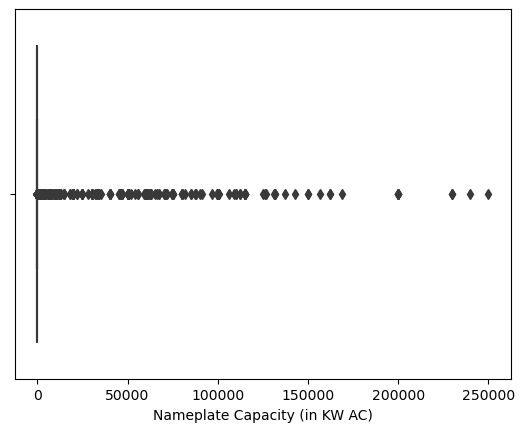

In [750]:
sns.boxplot(x=df['Nameplate Capacity (in KW AC)'].astype(float))
print(df['Nameplate Capacity (in KW AC)'].astype(float).max())


IQ Range:

In [751]:
Q1 = df['Nameplate Capacity (in KW AC)'].quantile(0.25)
Q3 = df['Nameplate Capacity (in KW AC)'].quantile(0.75)
IQR = Q3 - Q1

IQR

5.0

Finding unique values - 43 fuel types

In [752]:
df['Fuel Type'].nunique()

43

Standard Deviation

In [753]:
median_volt_fuel_type = df.groupby(['Fuel Type'])['Nameplate Capacity (in KW AC)'].median()

In [754]:
df['Nameplate Capacity (in KW AC)'].std()

2942.4482426643676

In [755]:
from scipy.stats import kurtosis, skew
print(skew(df['Nameplate Capacity (in KW AC)'], bias=False))
print(kurtosis(df['Nameplate Capacity (in KW AC)'], bias=False))

48.08888423909319
2760.73489443186


Difference in NamePlate Capacity by Fuel Type:

In [756]:
import plotly.graph_objects as go

# Get the median 'Nameplate Capacity (in KW AC)' for each 'Fuel Type'
median_capacity = df.groupby('Fuel Type')['Nameplate Capacity (in KW AC)'].median()

# Sort 'Fuel Type' by median capacity in descending order
sorted_fuel_types = median_capacity.sort_values(ascending=False).index

# Initialize a list to hold box plots
box_plots = []

# Add a box plot for all data
box_plots.append(
    go.Box(
        y=df['Nameplate Capacity (in KW AC)'],
        name='All Data',
        boxpoints='outliers',
        marker=dict(color='grey'),
        opacity=0.5
    )
)

# Add box plots for each fuel type
for fuel_type in sorted_fuel_types:
    box_plots.append(
        go.Box(
            y=df[df['Fuel Type'] == fuel_type]['Nameplate Capacity (in KW AC)'],
            name=fuel_type,
            boxpoints='outliers'
        )
    )

# Create the figure
fig = go.Figure(data=box_plots)

# Update layout with appropriate titles
fig.update_layout(
    title="Box plots of Nameplate Capacity by Fuel Type",
    xaxis_title="Fuel Type",
    yaxis_title="Nameplate Capacity (in KW AC)",
    xaxis=dict(tickangle=45),
    yaxis=dict(type="log")
)

# Show the figure
fig.show()


In [757]:
# Get the counts for each Fuel Type
fuel_type_counts = df['Fuel Type'].value_counts()

# Filter for classes with at least 400 records
selected_fuel_types = fuel_type_counts[fuel_type_counts >= 400].index

# Filter the DataFrame to include only these Fuel Types
df = df[df['Fuel Type'].isin(selected_fuel_types)]

# Display the result
df['Fuel Type'].value_counts()


Fuel Type
Battery                                   72839
Onsite Renewable_ Solar                   42724
Electric Grid_ Solar                      26853
Solar PV                                   8691
Electric Grid                              1075
Solar PV & Battery                          689
Electric Grid_ Onsite Renewable_ Solar      493
Name: count, dtype: int64

The median name plate capacity between fuel type groups has little variability

In [759]:
import plotly.graph_objects as go

# Get the median 'Nameplate Capacity (in KW AC)' for each 'Fuel Type'
median_capacity = df.groupby('Fuel Type')['Nameplate Capacity (in KW AC)'].median()

# Sort 'Fuel Type' by median capacity in descending order
sorted_fuel_types = median_capacity.sort_values(ascending=False).index

# Initialize a list to hold box plots
box_plots = []

# Add a box plot for all data
box_plots.append(
    go.Box(
        y=df['Nameplate Capacity (in KW AC)'],
        name='All Data',
        boxpoints='outliers',
        marker=dict(color='grey'),
        opacity=0.5
    )
)

# Add box plots for each fuel type
for fuel_type in sorted_fuel_types:
    box_plots.append(
        go.Box(
            y=df[df['Fuel Type'] == fuel_type]['Nameplate Capacity (in KW AC)'],
            name=fuel_type,
            boxpoints='outliers'
        )
    )

# Create the figure
fig = go.Figure(data=box_plots)

# Update layout with appropriate titles
fig.update_layout(
    title="Box plots of Nameplate Capacity by Fuel Type",
    xaxis_title="Fuel Type",
    yaxis_title="Nameplate Capacity (in KW AC)",
    xaxis=dict(tickangle=45),
    yaxis=dict(type="log")
)

# Show the figure
fig.show()


The majority of subgroups are residential

In [760]:

# Group by 'Fuel Type Group' and 'Customer Sector' and count the number of occurrences
df_grouped = df.groupby(['Fuel Type', 'Customer Sector']).size().reset_index(name='Count')

total_counts = df_grouped.groupby('Fuel Type')['Count'].transform('sum')
# Calculate the total number of customer sectors for each fuel type group
df_grouped['Percentage'] = (df_grouped['Count'] / total_counts * 100)

df_grouped

Fuel Type Customer Sector  Count  Percentage
0                                  Battery      Commercial   1845    2.532984
1                                  Battery     Residential  70766   97.153997
2                                  Battery         Utility    228    0.313019
3                            Electric Grid      Commercial    250   23.255814
4                            Electric Grid     Residential    825   76.744186
5   Electric Grid_ Onsite Renewable_ Solar      Commercial      4    0.811359
6   Electric Grid_ Onsite Renewable_ Solar     Residential    489   99.188641
7                     Electric Grid_ Solar      Commercial    296    1.102298
8                     Electric Grid_ Solar     Residential  26557   98.897702
9                  Onsite Renewable_ Solar      Commercial    227    0.531317
10                 Onsite Renewable_ Solar     Residential  42497   99.468683
11                                Solar PV      Commercial    100    1.150616
12                                Solar PV     Residential   8589   98.826372
13                                Solar PV         Utility      2    0.023012
14                      Solar PV & Battery      Commercial      3    0.435414
15                      Solar PV & Battery     Residential    684   99.274311
16                      Solar PV & Battery         Utility      2    0.290276

Let's look at utilities, and see the most frequent fuel type:

In [761]:
# Group by 'Fuel Type Group' and 'Customer Sector' and count the number of occurrences
df_grouped = df.groupby(['Fuel Type', 'Facility City']).size().reset_index(name='Count')

total_counts = df_grouped.groupby('Fuel Type')['Count'].transform('sum')
# Calculate the total number of customer sectors for each fuel type group
df_grouped['Percentage'] = (df_grouped['Count'] / total_counts * 100)

df_grouped

Fuel Type Facility City  Count  Percentage
0                Battery         ACTON      1    0.001373
1                Battery  AGOURA HILLS      1    0.001373
2                Battery   ALISO VIEJO      1    0.001373
3                Battery      ALTADENA      1    0.001373
4                Battery         Acton     92    0.126306
...                  ...           ...    ...         ...
2465  Solar PV & Battery         Ripon     24    3.483309
2466  Solar PV & Battery     Riverbank     10    1.451379
2467  Solar PV & Battery     Riverside    125   18.142235
2468  Solar PV & Battery        Salida     11    1.596517
2469  Solar PV & Battery     Waterford     10    1.451379

[2470 rows x 4 columns]

For most utilities, the most frequent fuel type group / type is battery

In [762]:
# Group by 'Fuel Type Group' and 'Utility' and count the occurrences
df_grouped = df.groupby(['Fuel Type', 'Utility']).size().reset_index(name='Count')

# Find the index of the maximum count for each 'Fuel Type Group'
idx = df_grouped.groupby(['Utility'])['Count'].idxmax()

# Select the rows with the maximum count for each 'Fuel Type Group'
df_max_count = df_grouped.loc[idx].reset_index(drop=True)

# Sort the result by 'Count' in descending order (optional)
df_max_count = df_max_count.sort_values(by='Count', ascending=False)
df_max_count['Fuel Type'].value_counts()


Fuel Type
Battery                    15
Solar PV                    5
Solar PV & Battery          3
Onsite Renewable_ Solar     1
Name: count, dtype: int64

Feature Engineering: We can classify counties by size to see if this impacts the fuel type group. We use the Z-score to create thresholds, then use it to classify counties 

In [763]:
def categorize_metrics(df, column):
    # Initialize result Series
    result = pd.Series(index=df.index, dtype="object")
    # Define tier labels
    tier_labels = ['Very low population', 'Low population', 'Medium population', 
                   'High population', 'Very high population']
    
    # Count occurrences by county
    county_sizes = df[column].value_counts()
    
    # Calculate quantiles for the county sizes
    Q1 = county_sizes.quantile(0.25)
    Q3 = county_sizes.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define fences
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    
    # Create bins
    bins = [-float('inf'), lower_fence, Q1, Q3, upper_fence, float('inf')]
    
    # Categorize counties
    categories = pd.cut(county_sizes, 
                       bins=bins, 
                       labels=tier_labels, 
                       include_lowest=True)
    
    # Create mapping dictionary
    county_category_map = dict(zip(county_sizes.index, categories))
    
    # Map categories back to original dataframe
    result = df[column].map(county_category_map)
    
    return result

# Apply the categorization
df['County_Population_Category'] = categorize_metrics(df, 'County')

Counties with high populations will tend to use battery energy, whereas medium to lower population counties will use Onsite Renewable energy

In [764]:
# Group by 'Fuel Type Group' and 'Utility' and count the occurrences
df_grouped = df.groupby(['Fuel Type', 'County_Population_Category']).size().reset_index(name='Count')

# Find the index of the maximum count for each 'Fuel Type Group'
idx = df_grouped.groupby(['County_Population_Category'])['Count'].idxmax()

# Select the rows with the maximum count for each 'Fuel Type Group'
df_max_count = df_grouped.loc[idx].reset_index(drop=True)

# Sort the result by 'Count' in descending order (optional)
df_max_count = df_max_count.sort_values(by='Count', ascending=False)
df_max_count

Fuel Type County_Population_Category  Count
3                  Battery       Very high population  62106
2  Onsite Renewable_ Solar          Medium population  15238
0  Onsite Renewable_ Solar            High population  11354
1  Onsite Renewable_ Solar             Low population    407

It would perhaps be interesting to see the number of cumulative approvals at the approval date and before, to if this has an effect on the type of fuel type group selection

In [765]:
import pandas as pd


df['Approval Date'] = pd.to_datetime(df['Approval Date'])

# Sort the DataFrame by 'Utility' and 'Approval Date' to get dates in chronological order for each utility
df = df.sort_values(by=['Utility', 'Approval Date'])

# Create a cumulative count of approvals within each utility group up to each approval date
df['Up_to_date_approvals_utility'] = df.groupby('Utility').cumcount()



Looking at each utility, and finding out the most frequently used fuel type groups used until the current date might be helpful to predict the next fuel type group

In [768]:
df

Utility  Nameplate Capacity (in KW AC) Fuel Type Facility City  \
153    Alameda                            6.8   Battery       Alameda   
154    Alameda                           10.0   Battery       Alameda   
155    Alameda                           10.0   Battery       Alameda   
156    Alameda                            5.0   Battery       Alameda   
157    Alameda                            5.0   Battery       Alameda   
...        ...                            ...       ...           ...   
97857    Ukiah                            5.0   Battery         Ukiah   
97884    Ukiah                            5.0   Battery         Ukiah   
97889    Ukiah                            5.0   Battery         Ukiah   
97892    Ukiah                           10.0   Battery         Ukiah   
97899    Ukiah                            5.0   Battery         Ukiah   

          County CAISO Flag  Facility Zip Customer Sector Approval Date  \
153      Alameda      OTHER         94501     Residential    2013-10-09   
154      Alameda      OTHER         94501     Residential    2019-03-12   
155      Alameda      OTHER         94501     Residential    2019-03-28   
156      Alameda      OTHER         94501     Residential    2019-04-17   
157      Alameda      OTHER         94501     Residential    2019-05-16   
...          ...        ...           ...             ...           ...   
97857  Mendocino      OTHER         95482     Residential    2022-01-28   
97884  Mendocino      OTHER         95482     Residential    2023-01-20   
97889  Mendocino      OTHER         95482     Residential    2023-03-15   
97892  Mendocino      OTHER         95482     Residential    2023-03-30   
97899  Mendocino      OTHER         95482     Residential    2023-10-26   

      County_Population_Category  Up_to_date_approvals_utility  
153         Very high population                             0  
154         Very high population                             1  
155         Very high population                             2  
156         Very high population                             3  
157         Very high population                             4  
...                          ...                           ...  
97857             Low population                             2  
97884             Low population                             3  
97889             Low population                             4  
97892             Low population                             5  
97899             Low population                             6  

[153364 rows x 11 columns]

In [766]:
import random

df2 = df.sample(50000, random_state=1).reset_index()

In [769]:
# Function to get the most frequent fuel type group from all prior records within the same utility
def get_most_frequent_prior_fuel_type(row, df):
    # Filter the DataFrame for the same utility and earlier dates
    prior_records = df[(df['Utility'] == row['Utility']) & (df['Approval Date'] < row['Approval Date'])]

    # Check if there are any prior records
    if prior_records.empty:
        return 'No prior records'
    else:
        # Calculate the most frequent fuel type group in prior records
        most_frequent = prior_records['Fuel Type'].value_counts()
        # Check if there are any values in most_frequent before getting idxmax
        if not most_frequent.empty:
            return most_frequent.idxmax()
        else:
            return 'No prior records'

# Apply the function within each utility group
df2['Most Frequent Prior Fuel Type'] = df2.apply(lambda row: get_most_frequent_prior_fuel_type(row, df), axis=1)

# Display the result
df2



index                     Utility  Nameplate Capacity (in KW AC)  \
0      142288  Southern California Edison                           6.00   
1       60048      Pacific Gas & Electric                           3.84   
2       13947      Pacific Gas & Electric                          15.00   
3       23717    San Diego Gas & Electric                          10.00   
4        1966      Pacific Gas & Electric                           9.90   
...       ...                         ...                            ...   
49995  143169  Southern California Edison                          10.00   
49996  141231  Southern California Edison                           7.60   
49997    8047      Pacific Gas & Electric                          10.00   
49998   55093      Pacific Gas & Electric                          10.00   
49999  133679  Southern California Edison                           9.60   

                     Fuel Type Facility City          County CAISO Flag  \
0                      Battery      Murrieta       Riverside      OTHER   
1      Onsite Renewable_ Solar      Petaluma          Sonoma      OTHER   
2         Electric Grid_ Solar     Clearlake            Lake      OTHER   
3                      Battery     Escondido       San Diego      OTHER   
4      Onsite Renewable_ Solar       Antioch    Contra Costa      OTHER   
...                        ...           ...             ...        ...   
49995                  Battery     La Mirada     Los Angeles      OTHER   
49996                  Battery         Chino  San Bernardino      OTHER   
49997     Electric Grid_ Solar    Bonny Doon      Santa Cruz      OTHER   
49998  Onsite Renewable_ Solar       Oakland         Alameda      OTHER   
49999                  Battery     Placentia          Orange      OTHER   

       Facility Zip Customer Sector Approval Date County_Population_Category  \
0             92563     Residential    2023-08-29       Very high population   
1             94952     Residential    2022-08-03            High population   
2             95422     Residential    2021-11-04          Medium population   
3             92027     Residential    2021-03-10       Very high population   
4             94531     Residential    2023-11-28       Very high population   
...             ...             ...           ...                        ...   
49995         90638     Residential    2023-09-11       Very high population   
49996         91710     Residential    2023-08-11       Very high population   
49997         95060     Residential    2021-01-19          Medium population   
49998         94619     Residential    2020-03-03       Very high population   
49999         92870     Residential    2019-02-26       Very high population   

       Up_to_date_approvals_utility Most Frequent Prior Fuel Type  
0                             39222                       Battery  
1                             42770          Electric Grid_ Solar  
2                             27965          Electric Grid_ Solar  
3                              8268                       Battery  
4                             70328       Onsite Renewable_ Solar  
...                             ...                           ...  
49995                         40106                       Battery  
49996                         38161                       Battery  
49997                         16990          Electric Grid_ Solar  
49998                          7677          Electric Grid_ Solar  
49999                          3777                       Battery  

[50000 rows x 13 columns]

# Feature Engineering

### CLustering Algorithm - Creating unique profiles of grouped variables

In [794]:
df = df2.copy().reset_index().drop(columns=['index', 'level_0'])

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\U355394\New folder\envs\Lib\site-packa

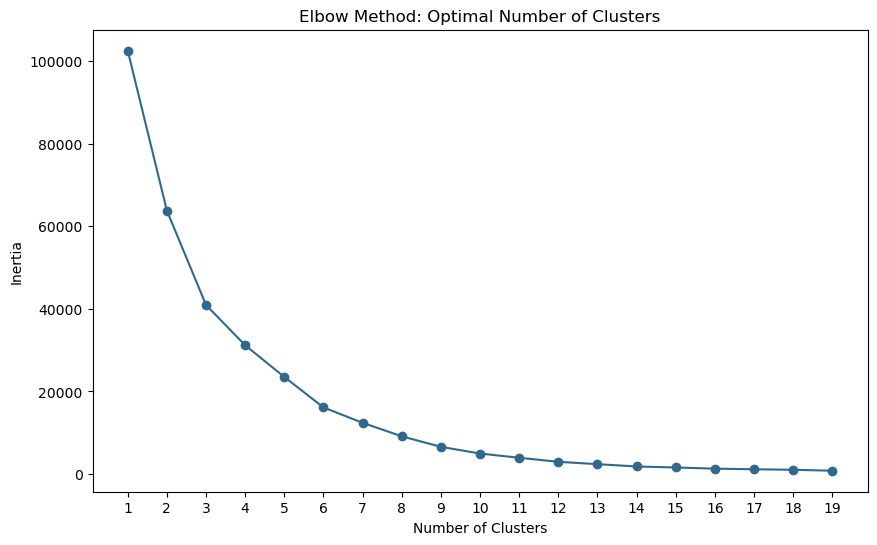

In [795]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
# Separate numerical and categorical columns
numerical_features = df[['Nameplate Capacity (in KW AC)']]
categorical_features = df[['County_Population_Category', 'Utility']]

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_categorical = encoder.fit_transform(categorical_features)

# Standardize numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(numerical_features)

# Combine the scaled numerical features and the encoded categorical features
combined_features = np.hstack([scaled_numerical, encoded_categorical])

# KMeans clustering with the combined features
inertia = []
k_range = range(1, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

In [796]:
# Pick optimal number of pitchers from plot above
optimal_k = 8
# Cluster pitchers by their average values
kmeans = KMeans(n_clusters = optimal_k)
df['cluster'] = kmeans.fit_predict(combined_features)


c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



# Model

### Taking the class with minimum value

In [797]:
target='Fuel Type'
df = df.groupby(target, group_keys=False)
df = pd.DataFrame(df.apply(lambda x: x.sample(df.size().min()))).reset_index()
df['Fuel Type'].value_counts()


Fuel Type
Battery                                   166
Electric Grid                             166
Electric Grid_ Onsite Renewable_ Solar    166
Electric Grid_ Solar                      166
Onsite Renewable_ Solar                   166
Solar PV                                  166
Solar PV & Battery                        166
Name: count, dtype: int64

In [798]:
df

index                      Utility  Nameplate Capacity (in KW AC)  \
0     29802   Southern California Edison                           10.0   
1     44733   Southern California Edison                            5.0   
2     21710     San Diego Gas & Electric                           10.0   
3      8558   Southern California Edison                            7.0   
4     20532   Southern California Edison                            7.6   
...     ...                          ...                            ...   
1157   6389  Modesto Irrigation District                            5.0   
1158   2173             City of Glendale                            5.0   
1159  30530             City of Glendale                            5.0   
1160  36486  Modesto Irrigation District                            5.0   
1161  36480  Modesto Irrigation District                            5.0   

               Fuel Type   Facility City       County CAISO Flag  \
0                Battery  Corona Del Mar       Orange      OTHER   
1                Battery         Ventura      Ventura      OTHER   
2                Battery       San Diego    San Diego      OTHER   
3                Battery     Culver City  Los Angeles      OTHER   
4                Battery         Gardena  Los Angeles      OTHER   
...                  ...             ...          ...        ...   
1157  Solar PV & Battery         Modesto   Stanislaus      OTHER   
1158  Solar PV & Battery        Glendale  Los Angeles      OTHER   
1159  Solar PV & Battery        Glendale  Los Angeles      OTHER   
1160  Solar PV & Battery         Modesto   Stanislaus      OTHER   
1161  Solar PV & Battery         Modesto   Stanislaus      OTHER   

      Facility Zip Customer Sector Approval Date County_Population_Category  \
0            92625     Residential    2023-11-20       Very high population   
1            93004     Residential    2023-09-06            High population   
2            92130     Residential    2022-05-23       Very high population   
3            90230     Residential    2023-09-11       Very high population   
4            90249     Residential    2021-06-22       Very high population   
...            ...             ...           ...                        ...   
1157         95357     Residential    2021-04-28          Medium population   
1158         91201     Residential    2022-11-10       Very high population   
1159         91201     Residential    2023-06-28       Very high population   
1160         95356     Residential    2018-03-22          Medium population   
1161         95351     Residential    2019-12-26          Medium population   

      Up_to_date_approvals_utility Most Frequent Prior Fuel Type  cluster  
0                            45850                       Battery        0  
1                            39871                       Battery        0  
2                            13306                       Battery        4  
3                            40108                       Battery        0  
4                            15128                       Battery        0  
...                            ...                           ...      ...  
1157                           107            Solar PV & Battery        5  
1158                           104            Solar PV & Battery        7  
1159                           143            Solar PV & Battery        7  
1160                             5            Solar PV & Battery        5  
1161                            51            Solar PV & Battery        5  

[1162 rows x 14 columns]

Selecting Target and Explanatory Variables

In [799]:
# Automatically select all columns except 'pitch_type'
# Select features (X) and the target variable (y) using the filtered columns
X = df.loc[:,['cluster', 'Utility']]
y = df['Fuel Type']

In [800]:
encoder = OneHotEncoder(sparse=False)
X = encoder.fit_transform(X.values)
X.shape



c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



(1162, 18)

In [801]:
y = encoder.fit_transform(y.values.reshape(-1, 1)).argmax(axis=1)

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Separating Training and Testing Set

In [802]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
 X,
 y,
 test_size=0.2,
 random_state=4
)


In [803]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Lasso (L1) Regularization with Cross-Validation
model = LogisticRegressionCV(
 Cs=10, # Number of regularization strengths to test
 cv=5, # 5-fold cross-validation
 penalty='l1', # Lasso (L1) regularization
 solver='liblinear', # L1 requires liblinear solver
 max_iter=100,
 scoring='accuracy', # Use accuracy to choose the best model
 random_state=42
)
# Fit the model with cross-validation
model.fit(x_train, y_train)
# Make predictions
y_pred = model.predict(x_test)
# Print accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))


c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Accuracy: 0.57
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.22      1.00      0.36        29
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00        32
           5       1.00      0.79      0.89        39
           6       1.00      1.00      1.00        32

    accuracy                           0.57       233
   macro avg       0.46      0.54      0.46       233
weighted avg       0.50      0.57      0.50       233



c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.22      1.00      0.36        29
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00        32
           5       1.00      0.79      0.89        39
           6       1.00      1.00      1.00        32

    accuracy                           0.57       233
   macro avg       0.46      0.54      0.46       233
weighted avg       0.50      0.57      0.50       233



c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



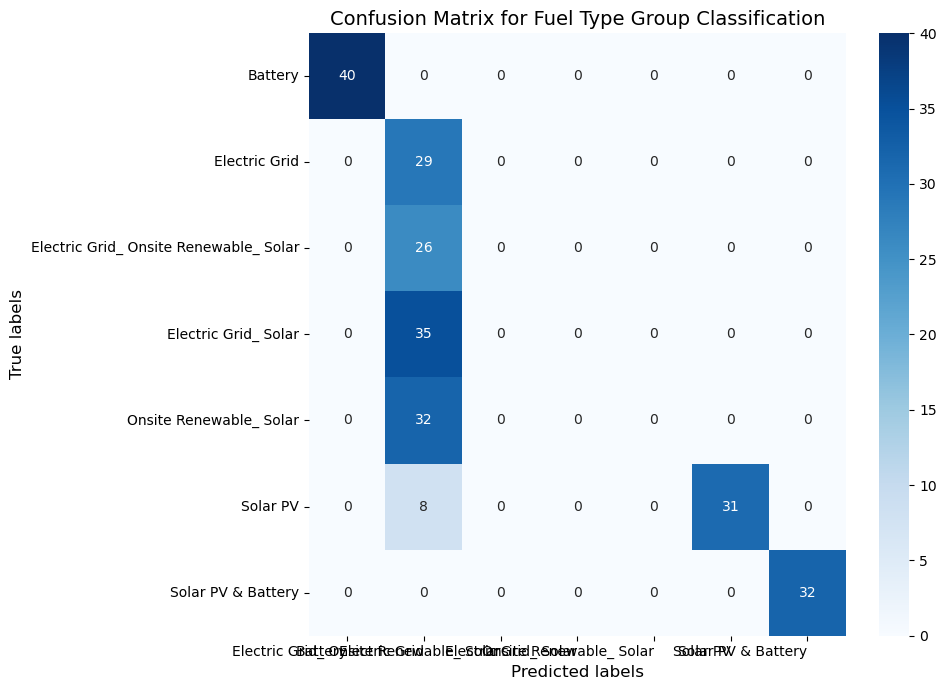

In [804]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_test_encoded and y_pred are already defined
# Generate a classification report
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique pitch types to label the confusion matrix
pitch_types = encoder.categories_[0]  # This will give the pitch type names

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=pitch_types, columns=pitch_types)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')  # fmt='g' ensures integer format

# Add labels, title, and ticks
ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_title('Confusion Matrix for Fuel Type Group Classification', fontsize=14)

# Set tick labels for x and y axis using the pitch type names
ax.xaxis.set_ticklabels(pitch_types, rotation=0, ha="right", fontsize=10)
ax.yaxis.set_ticklabels(pitch_types, rotation=0, fontsize=10)  # Keep vertical

plt.tight_layout()  # Adjust layout to fit labels
plt.show()


c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\U355394\New folder\envs\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.5708
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.31      0.55      0.40        29
           2       0.20      0.62      0.30        26
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00        32
           5       1.00      0.79      0.89        39
           6       0.94      1.00      0.97        32

    accuracy                           0.57       233
   macro avg       0.49      0.56      0.50       233
weighted avg       0.53      0.57      0.53       233



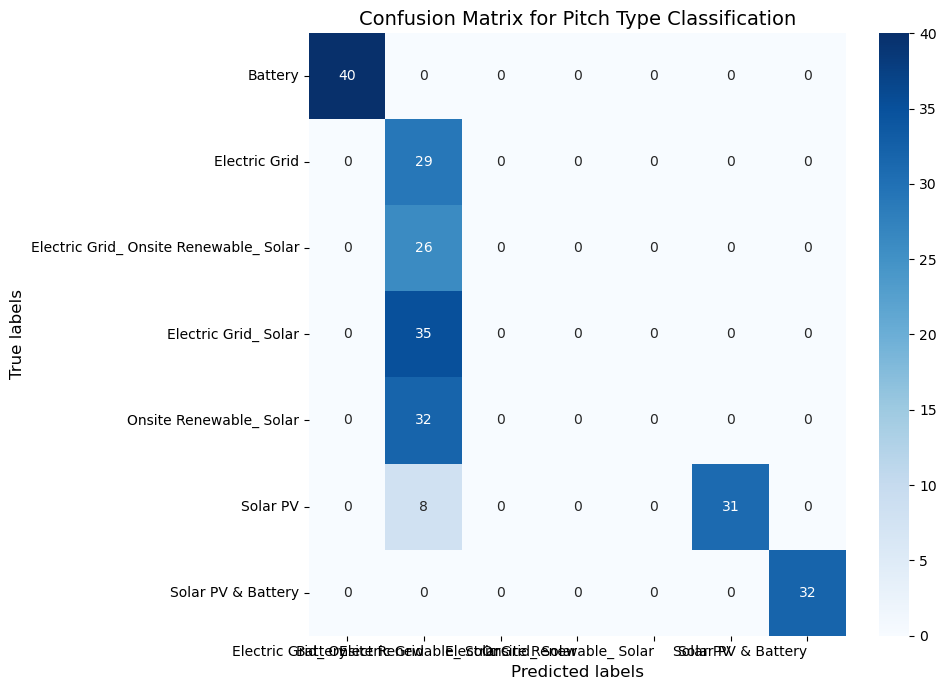

In [805]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest Classifier with additional parameters
rf_classifier = RandomForestClassifier(
 n_estimators=100, # Number of trees In [218…
 max_depth=100, # Maximum depth of the tree
 min_samples_split=8, # Minimum samples to split a node
 min_samples_leaf=16, # Minimum samples at a leaf node
 max_features=0.25, # Number of features to consider for best split
 bootstrap=True, # Use bootstrap samples
 criterion="gini", # Use Gini impurity to split
 random_state=42
)
# Train the classifier
rf_classifier.fit(x_train, y_train)
# Make predictions on the test set
y_pred = rf_classifier.predict(x_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
# Generate a classification report
print(f"Accuracy: {accuracy:.4f}")
print(classification_rep)
# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g') # fmt='g' ensure
# Add labels, title, and ticks
ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_title('Confusion Matrix for Pitch Type Classification', fontsize=14)
# Set tick labels for x and y axis using the pitch type names
ax.xaxis.set_ticklabels(pitch_types, rotation=0, ha="right", fontsize=10) #
ax.yaxis.set_ticklabels(pitch_types, rotation=0, fontsize=10) # Keep vertic
plt.tight_layout() # Adjust layout to fit labels
plt.show()


In [806]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': x_train.columns,  # Column names of your features
    'Importance': rf_classifier.feature_importances_
})

# Extract prefix (before the last '_') and group the importance values by the prefix
feature_importances_df['Prefix'] = feature_importances_df['Feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# Group by the prefix and sum the importances
grouped_importances_df = feature_importances_df.groupby('Prefix')['Importance'].sum().reset_index()

feature_importances_df


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

Find feature importance:

Feature Importances DataFrame:
                         Feature  Importance
0           Cumulative Approvals    0.173878
1                   Facility Zip    0.111702
2  Nameplate Capacity (in KW AC)    0.040588
3                        cluster    0.030185
4                          index    0.031429
Feature Importances with Prefixes:
                         Feature  Importance                         Prefix
0           Cumulative Approvals    0.173878           Cumulative Approvals
1                   Facility Zip    0.111702                   Facility Zip
2  Nameplate Capacity (in KW AC)    0.040588  Nameplate Capacity (in KW AC)
3                        cluster    0.030185                        cluster
4                          index    0.031429                          index
Grouped Feature Importances:
                           Prefix  Importance
7   Most Frequent Prior Fuel Type    0.343714
9                         Utility    0.226231
3            Cumulative Approvals    0.17

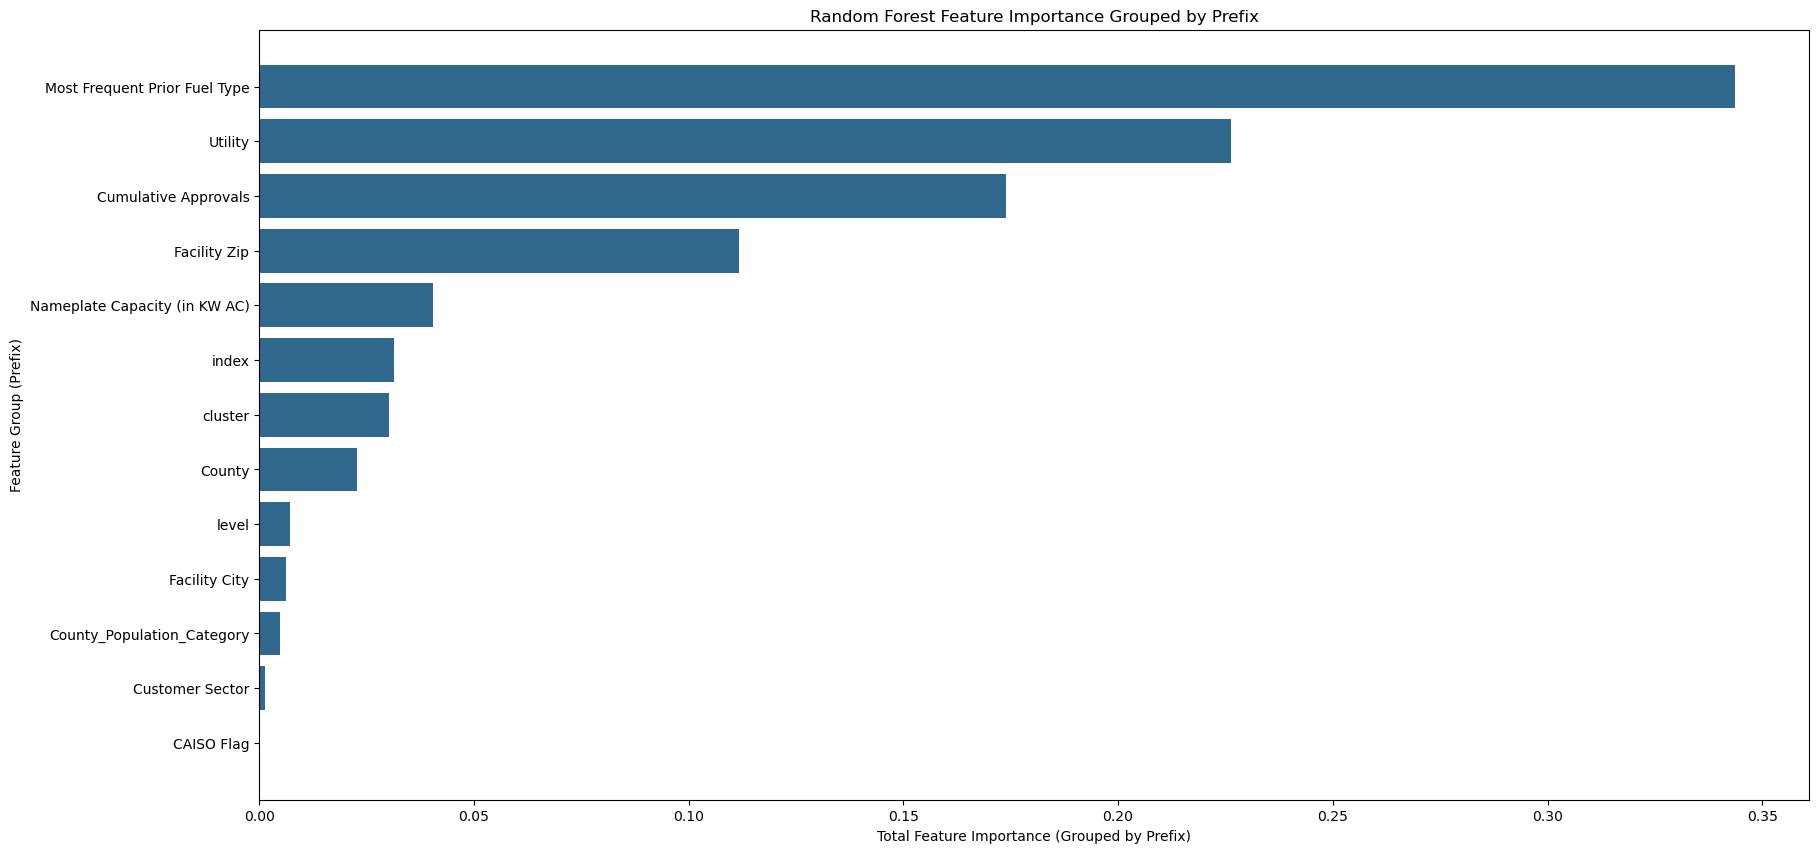

In [542]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': x_train.columns,  # Column names of your features
    'Importance': rf_classifier.feature_importances_
})

# Check if the DataFrame is created correctly
print("Feature Importances DataFrame:")
print(feature_importances_df.head())

# Extract prefix (before the last '_') and if no prefix exists, keep the feature name as-is
feature_importances_df['Prefix'] = feature_importances_df['Feature'].apply(
    lambda x: '_'.join(x.split('_')[:-1]) if '_' in x else x
)

# Check if the prefixes are created correctly
print("Feature Importances with Prefixes:")
print(feature_importances_df.head())

# Group by the prefix and sum the importances
grouped_importances_df = feature_importances_df.groupby('Prefix')['Importance'].sum().reset_index()

# Sort the grouped importances by descending order
grouped_importances_df = grouped_importances_df.sort_values(by='Importance', ascending=False)

# Display the grouped feature importance
print("Grouped Feature Importances:")
print(grouped_importances_df)

# Plot the grouped feature importances
plt.figure(figsize=(20, 10))
plt.barh(grouped_importances_df['Prefix'], grouped_importances_df['Importance'])
plt.xlabel('Total Feature Importance (Grouped by Prefix)')
plt.ylabel('Feature Group (Prefix)')
plt.title('Random Forest Feature Importance Grouped by Prefix')

plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()
